# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [10]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


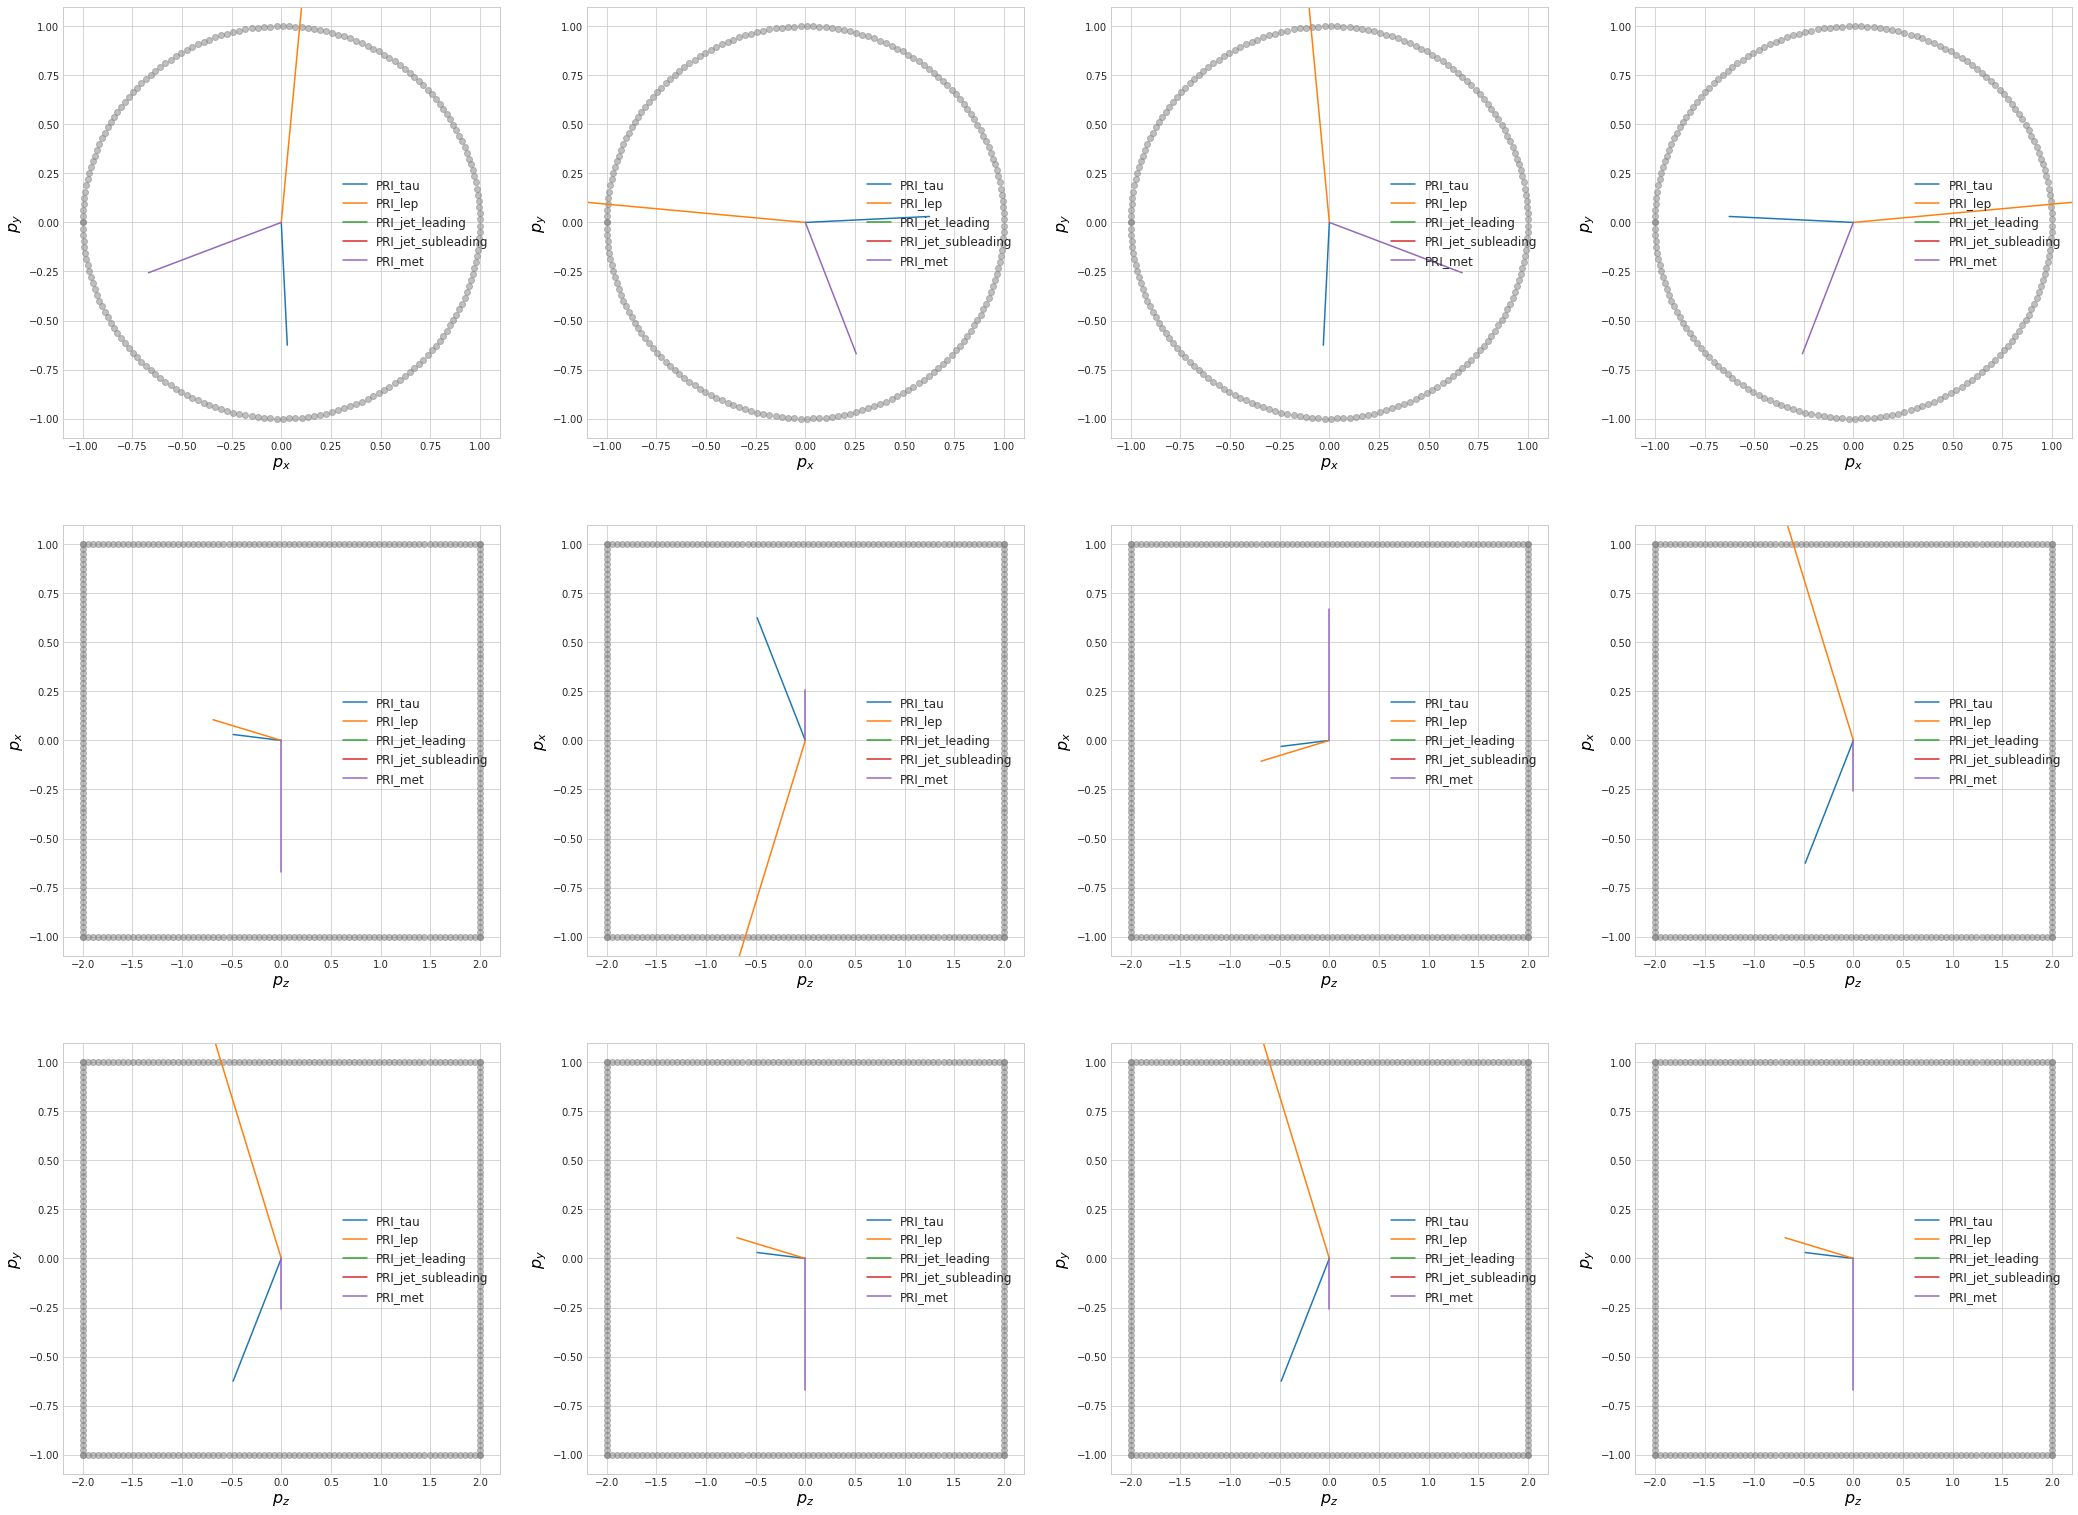

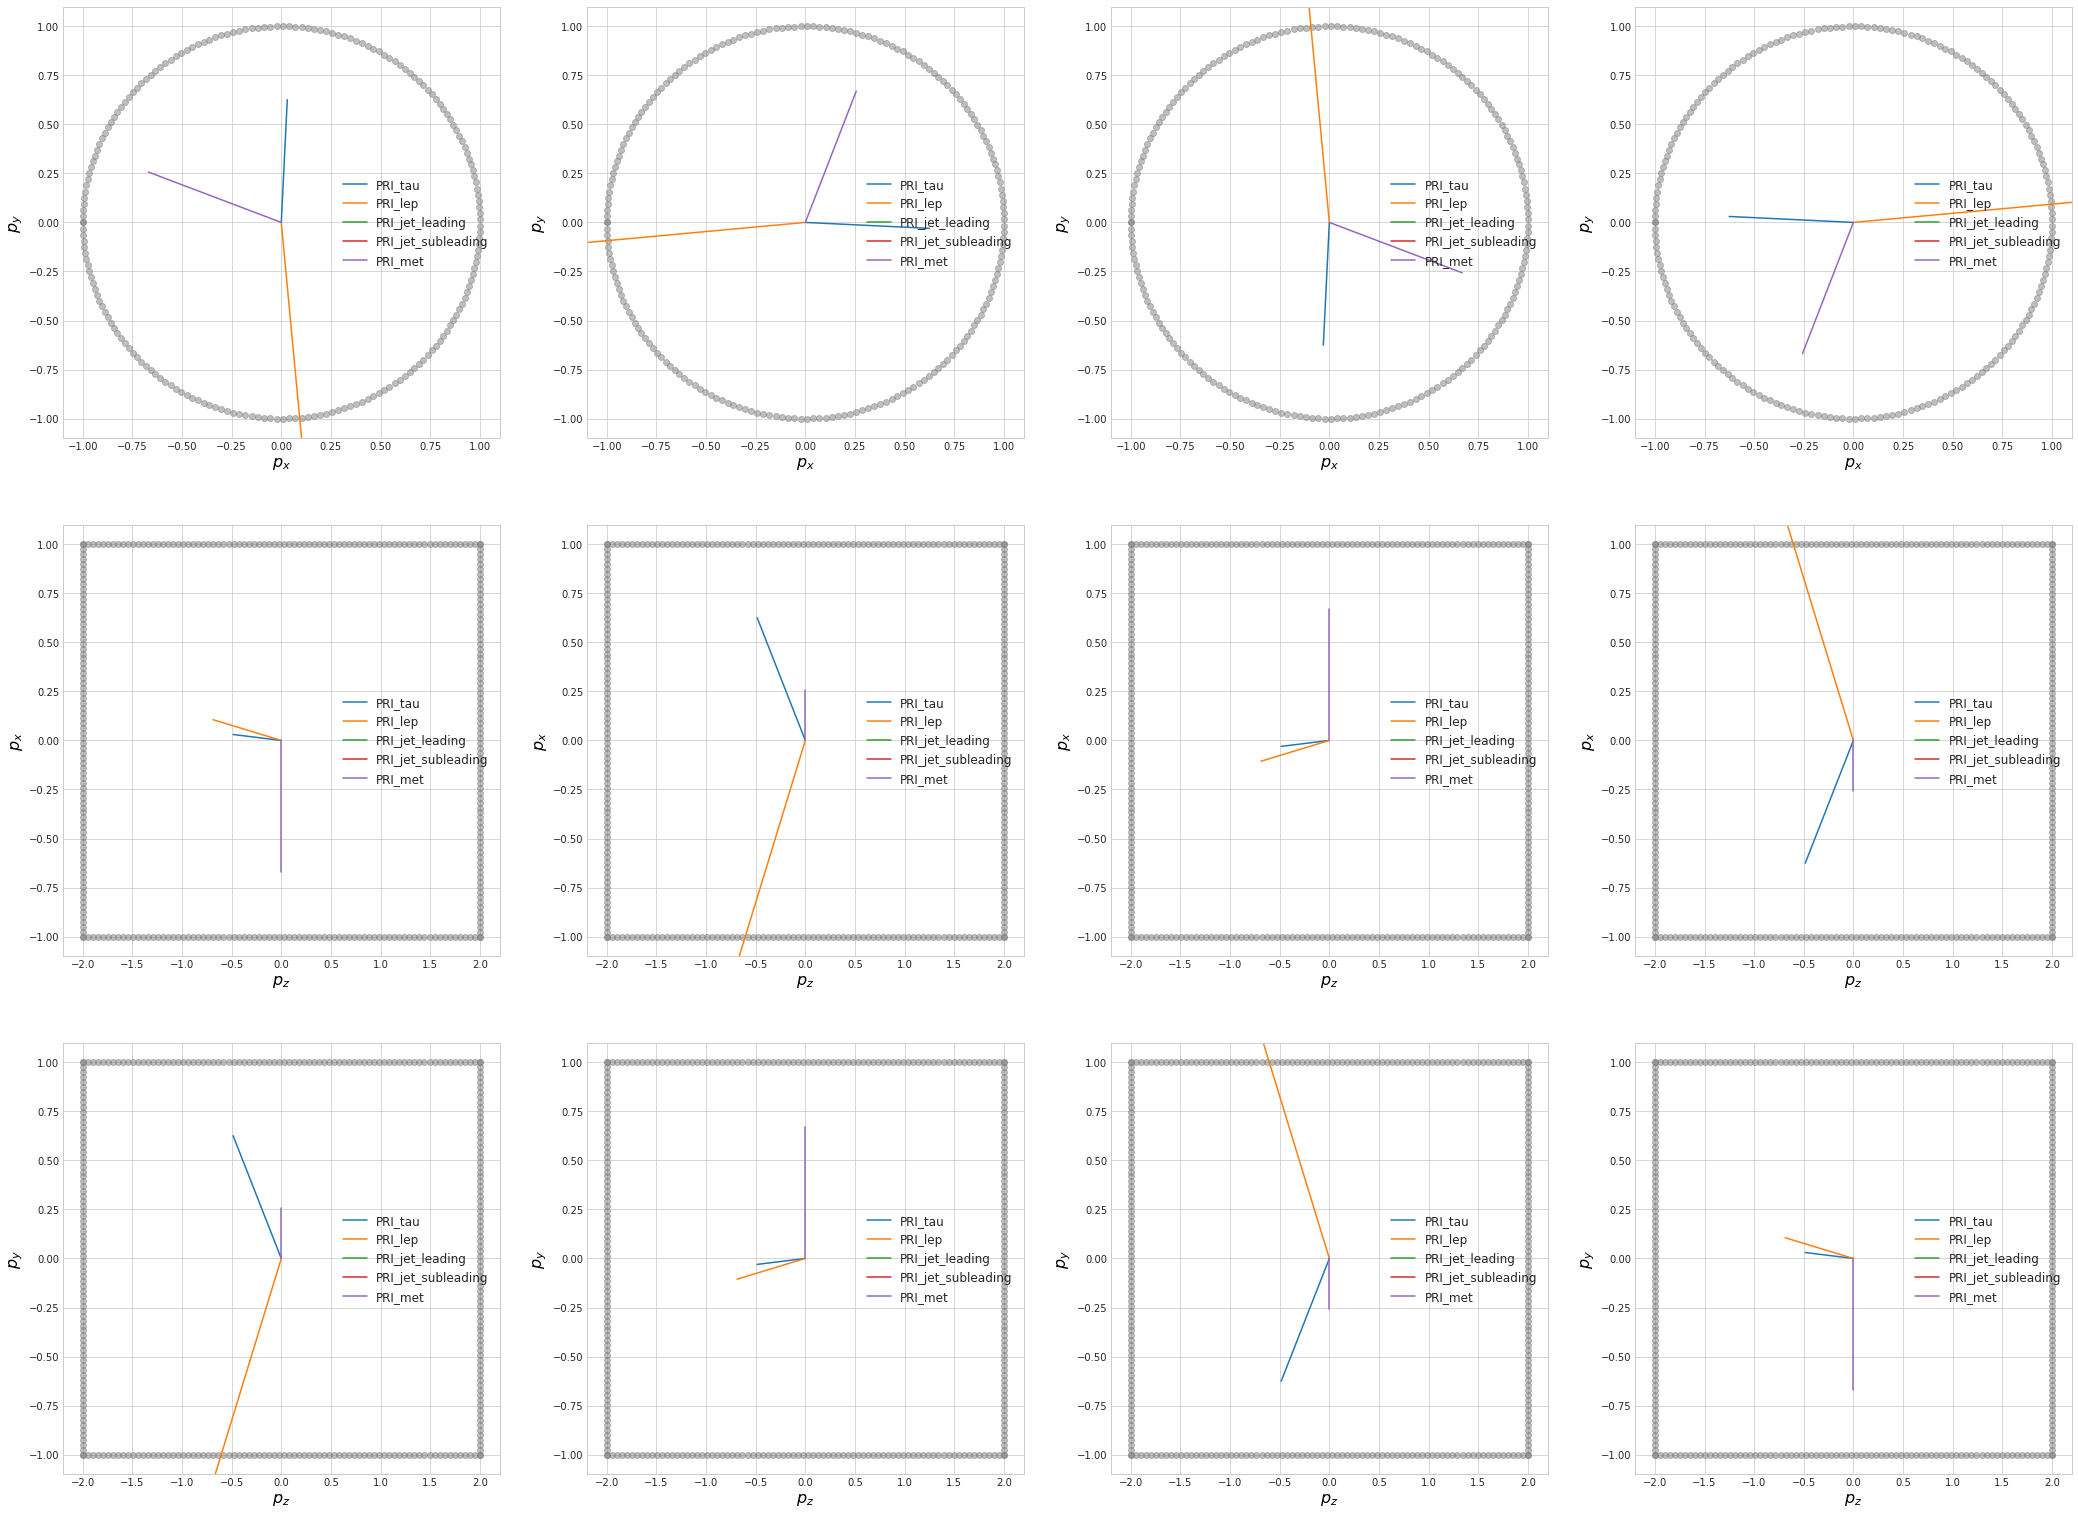

In [6]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 18.260s 


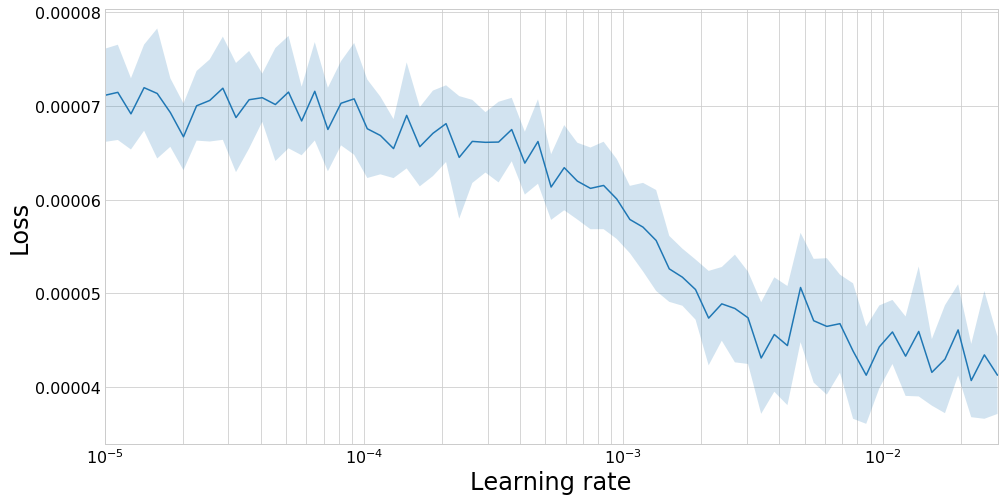

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [11]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277824). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139334). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1069778724340724e-05
2 New best found: 3.5996338899713006e-05
3 New best found: 3.535674073064001e-05
4 New best found: 3.505571781424805e-05
5 New best found: 3.3937412552768366e-05
6 New best found: 3.382755051279673e-05
7 New best found: 3.371623732818989e-05
9 New best found: 3.357218397723045e-05
11 New best found: 3.288781574956374e-05
12 New best found: 3.2719829633424524e-05
13 New best found: 3.2632951534469614e-05
14 New best found: 3.242877600860083e-05
15 New best found: 3.242342024022946e-05
24 New best found: 3.226327605370898e-05
27 New best found: 3.2160847121849654e-05
28 New best found: 3.205317523097619e-05
29 New best found: 3.1976508935622405e-05
30 New best found: 3.1961882693576626e-05
31 New best found: 3.195999344170559e-05
44 New best found: 3.193511028657668e-05
45 New best found: 3.188474521011812e-05
50 New best found: 3.169789521198254e-05
53 New best found: 3.16920943572768e-05
55 New best found: 3.1683595743379556e-05
56 New best foun

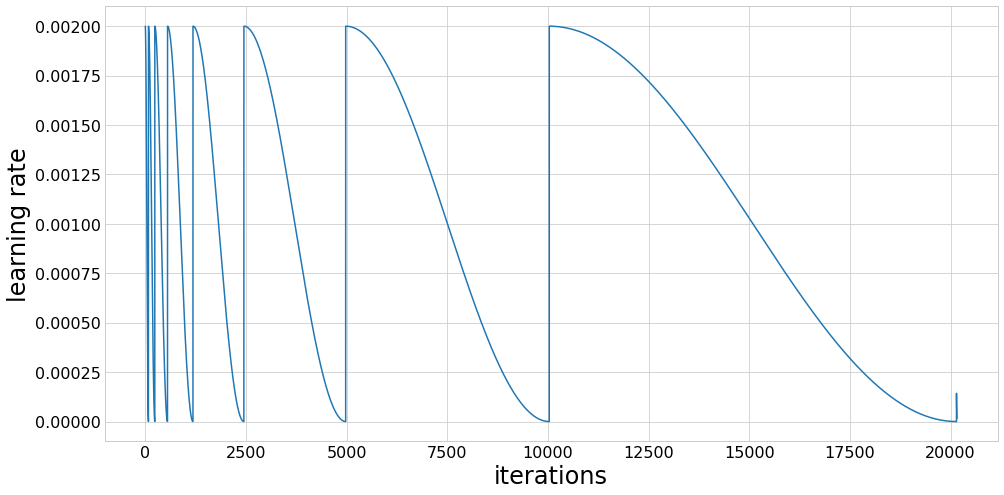

Fold took 292.197s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299975). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150330). Check your callbacks.
  % delta_t_median)


1 New best found: 3.932822640927043e-05
2 New best found: 3.6747334856772795e-05
3 New best found: 3.5138978896429764e-05
4 New best found: 3.4842053170723374e-05
5 New best found: 3.435576733463677e-05
6 New best found: 3.354954475653358e-05
7 New best found: 3.3399728451331614e-05
11 New best found: 3.3143013472727035e-05
12 New best found: 3.2754553003178445e-05
13 New best found: 3.253445361187914e-05
14 New best found: 3.2408609724370763e-05
15 New best found: 3.238342984404881e-05
21 New best found: 3.236612296605017e-05
24 New best found: 3.2231979022617455e-05
25 New best found: 3.2094549786415885e-05
27 New best found: 3.197787103854353e-05
28 New best found: 3.1966006504080727e-05
29 New best found: 3.186481241136789e-05
30 New best found: 3.186345793073997e-05
31 New best found: 3.185880317469128e-05
47 New best found: 3.1762274922220967e-05
52 New best found: 3.172287570196204e-05
53 New best found: 3.1649263319559396e-05
54 New best found: 3.161610346287489e-05
56 New best

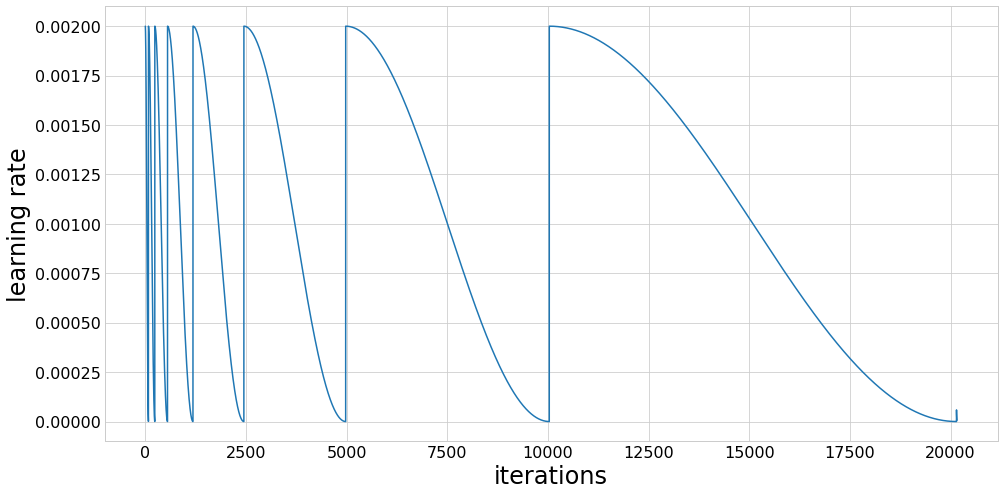

Fold took 298.224s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.333435). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167248). Check your callbacks.
  % delta_t_median)


1 New best found: 4.000793045415776e-05
2 New best found: 3.683687182201538e-05
3 New best found: 3.5748350516951175e-05
5 New best found: 3.477484522736631e-05
6 New best found: 3.409422761396854e-05
7 New best found: 3.4004222246585415e-05
10 New best found: 3.3821992872981355e-05
12 New best found: 3.373939394732588e-05
13 New best found: 3.362546560820192e-05
14 New best found: 3.3360406108840837e-05
15 New best found: 3.3303551668359435e-05
23 New best found: 3.327620729105547e-05
24 New best found: 3.321123874775367e-05
25 New best found: 3.29169601900503e-05
26 New best found: 3.282204335046117e-05
28 New best found: 3.267915946780704e-05
29 New best found: 3.261701725423336e-05
30 New best found: 3.258495646296069e-05
31 New best found: 3.2580552593572066e-05
47 New best found: 3.252858851774363e-05
48 New best found: 3.249625271710102e-05
49 New best found: 3.243757398668095e-05
52 New best found: 3.232351982442197e-05
55 New best found: 3.224654185614782e-05
57 New best found

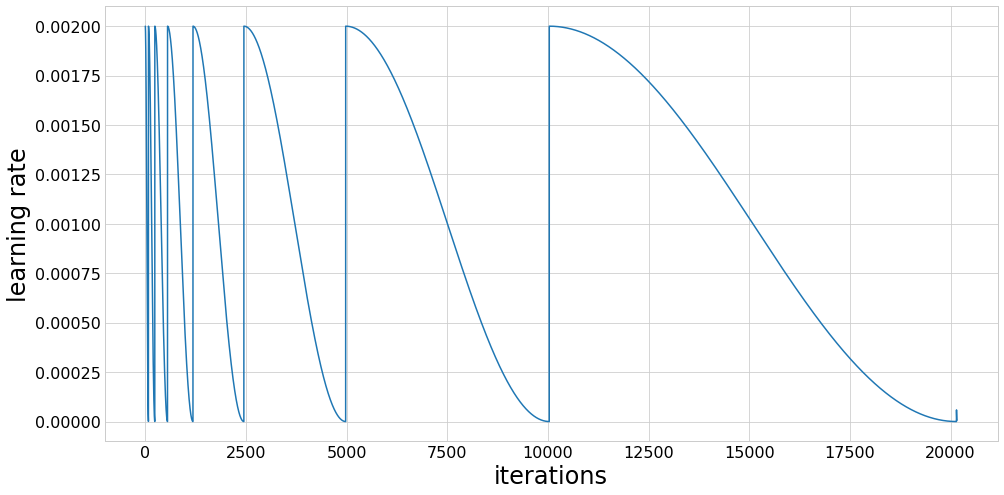

Fold took 303.374s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.362602). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181786). Check your callbacks.
  % delta_t_median)


1 New best found: 4.038157897446719e-05
2 New best found: 3.668696839851427e-05
3 New best found: 3.5917746653107704e-05
4 New best found: 3.583176640021524e-05
5 New best found: 3.472774321169107e-05
6 New best found: 3.430606830756949e-05
7 New best found: 3.4168050635934047e-05
10 New best found: 3.4134917995436315e-05
11 New best found: 3.3503640496669456e-05
13 New best found: 3.318891425302056e-05
14 New best found: 3.305609841066014e-05
15 New best found: 3.30340515536498e-05
25 New best found: 3.267233349500131e-05
28 New best found: 3.262700220804196e-05
29 New best found: 3.2622822973698494e-05
30 New best found: 3.260989505373764e-05
31 New best found: 3.260354999103228e-05
46 New best found: 3.2577728867895384e-05
48 New best found: 3.2501739248992966e-05
50 New best found: 3.2468775288724355e-05
53 New best found: 3.238419565185156e-05
55 New best found: 3.224142836576831e-05
56 New best found: 3.221396823103745e-05
58 New best found: 3.216351000434042e-05
61 New best foun

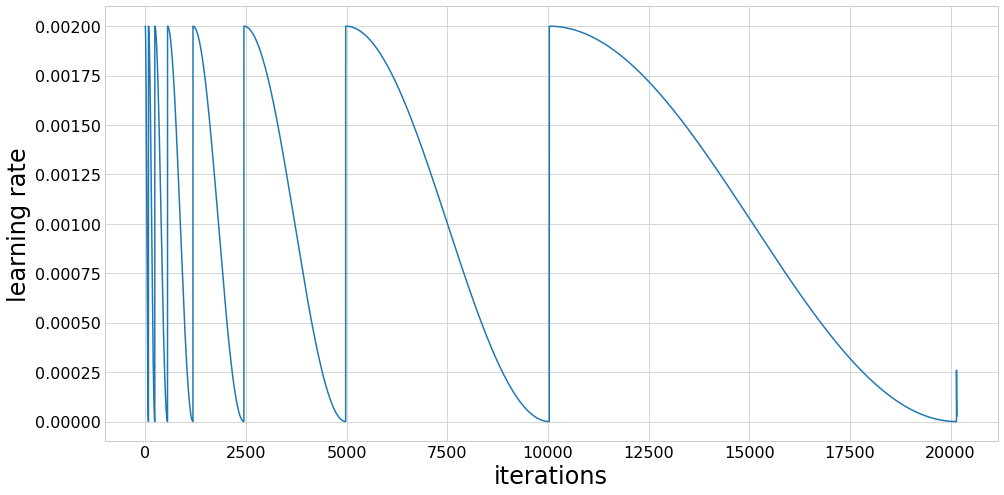

Fold took 303.960s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.394601). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197778). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1077350286933384e-05
2 New best found: 3.739939122473182e-05
3 New best found: 3.653404001269718e-05
5 New best found: 3.607806821950066e-05
6 New best found: 3.504578506124326e-05
7 New best found: 3.48938967911631e-05
10 New best found: 3.4497999604294594e-05
12 New best found: 3.419515815430836e-05
13 New best found: 3.4015823908685674e-05
14 New best found: 3.388657010789801e-05
15 New best found: 3.385779936450469e-05
20 New best found: 3.378174500832901e-05
22 New best found: 3.369928136468067e-05
24 New best found: 3.3650854360951226e-05
25 New best found: 3.352286641641842e-05
26 New best found: 3.344908718604446e-05
27 New best found: 3.34086714202119e-05
28 New best found: 3.3306504060063236e-05
29 New best found: 3.328911816964792e-05
30 New best found: 3.327331672844039e-05
31 New best found: 3.327134599723044e-05
47 New best found: 3.318629899044804e-05
55 New best found: 3.301215112265218e-05
56 New best found: 3.300814484398749e-05
57 New best found: 

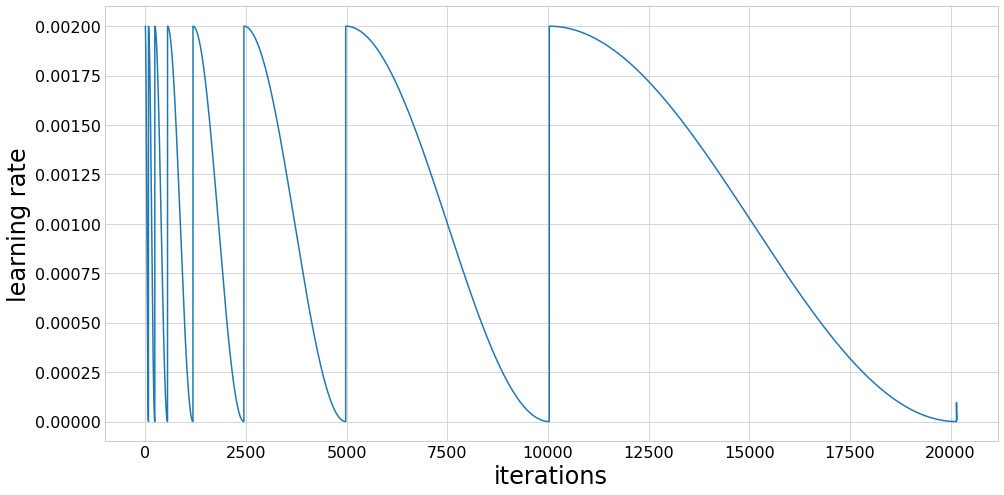

Fold took 305.365s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.446642). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223778). Check your callbacks.
  % delta_t_median)


1 New best found: 4.05083623729297e-05
2 New best found: 3.730833658482879e-05
3 New best found: 3.645813381881453e-05
5 New best found: 3.551360277197091e-05
6 New best found: 3.505378272966482e-05
7 New best found: 3.49589958685101e-05
9 New best found: 3.4643975635117387e-05
12 New best found: 3.43491743580671e-05
13 New best found: 3.412042203126475e-05
14 New best found: 3.4009373413573485e-05
15 New best found: 3.4000473591731864e-05
21 New best found: 3.394966540945461e-05
24 New best found: 3.379157002054853e-05
25 New best found: 3.3706539749982765e-05
26 New best found: 3.369520168344025e-05
27 New best found: 3.356179099500878e-05
28 New best found: 3.354040255799191e-05
29 New best found: 3.346397086133948e-05
30 New best found: 3.343472664710134e-05
48 New best found: 3.3376175093872005e-05
50 New best found: 3.3363363741955256e-05
51 New best found: 3.3303792364313264e-05
52 New best found: 3.3256223090575074e-05
53 New best found: 3.31907862884691e-05
54 New best found: 

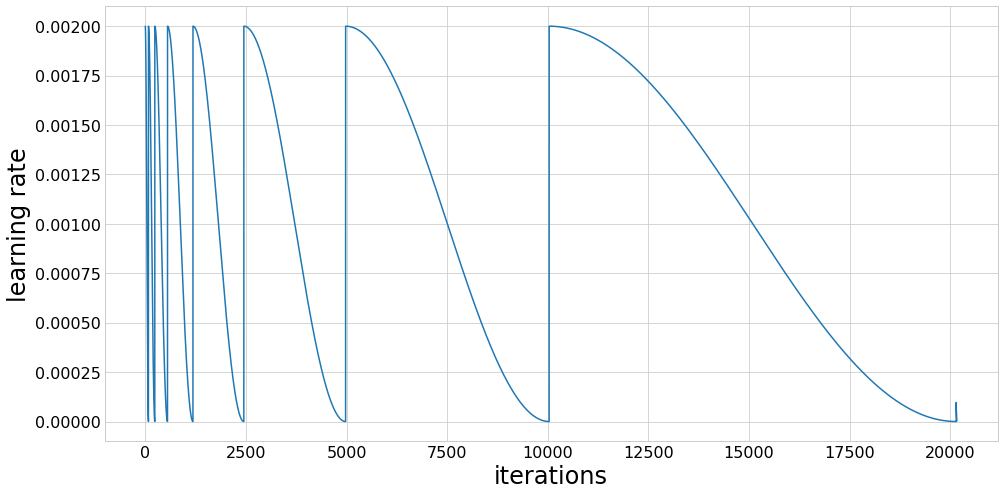

Fold took 317.654s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.523273). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262030). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9825160436020154e-05
2 New best found: 3.641485144874385e-05
3 New best found: 3.580596371645924e-05
4 New best found: 3.568153402900688e-05
5 New best found: 3.481086437542006e-05
6 New best found: 3.432937513176201e-05
7 New best found: 3.408061859783766e-05
10 New best found: 3.383926322728229e-05
11 New best found: 3.3795293897792575e-05
12 New best found: 3.3198031785012376e-05
13 New best found: 3.306135539481541e-05
14 New best found: 3.2942710167702894e-05
15 New best found: 3.292012665106271e-05
21 New best found: 3.277800672692736e-05
25 New best found: 3.273455692942544e-05
26 New best found: 3.259081485138667e-05
28 New best found: 3.252103934768957e-05
29 New best found: 3.2502865148770395e-05
30 New best found: 3.2471299878024405e-05
31 New best found: 3.2466522121493925e-05
48 New best found: 3.227106102489586e-05
53 New best found: 3.2211171411359425e-05
54 New best found: 3.21843695368688e-05
55 New best found: 3.212754312686411e-05
56 New best foun

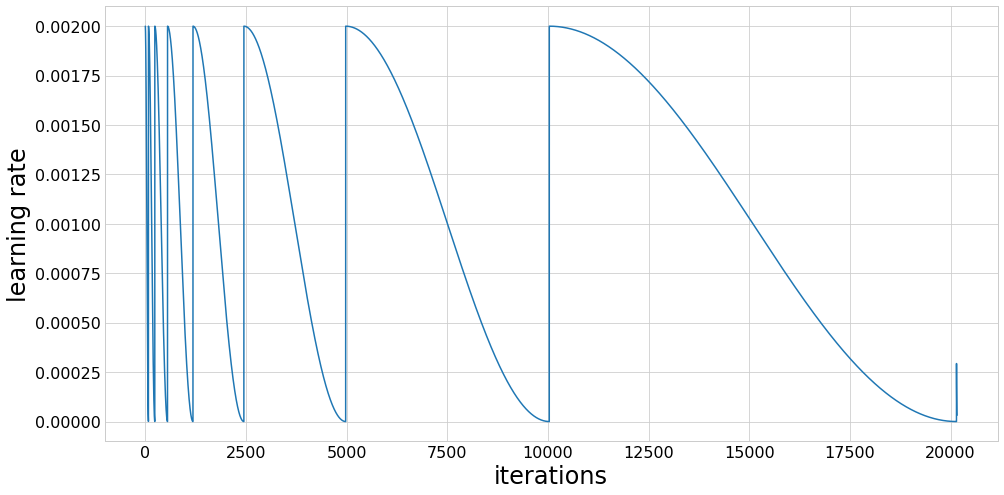

Fold took 317.651s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.508194). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254545). Check your callbacks.
  % delta_t_median)


1 New best found: 3.990091310454694e-05
2 New best found: 3.694384211805829e-05
3 New best found: 3.573123598426084e-05
4 New best found: 3.546797305371973e-05
5 New best found: 3.469633512664073e-05
6 New best found: 3.39948226097593e-05
7 New best found: 3.3891745075730054e-05
11 New best found: 3.382886020860252e-05
12 New best found: 3.3168505233303224e-05
13 New best found: 3.28848044691817e-05
14 New best found: 3.282432285320051e-05
15 New best found: 3.279236650358721e-05
23 New best found: 3.259759263520937e-05
25 New best found: 3.25725761215066e-05
26 New best found: 3.241678802174351e-05
28 New best found: 3.229188635225332e-05
30 New best found: 3.226686928089901e-05
31 New best found: 3.226238111086918e-05
45 New best found: 3.225776220151026e-05
49 New best found: 3.218178083146873e-05
50 New best found: 3.206854704022332e-05
53 New best found: 3.2032833242596057e-05
55 New best found: 3.1987457913673136e-05
56 New best found: 3.196975099574697e-05
58 New best found: 3.1

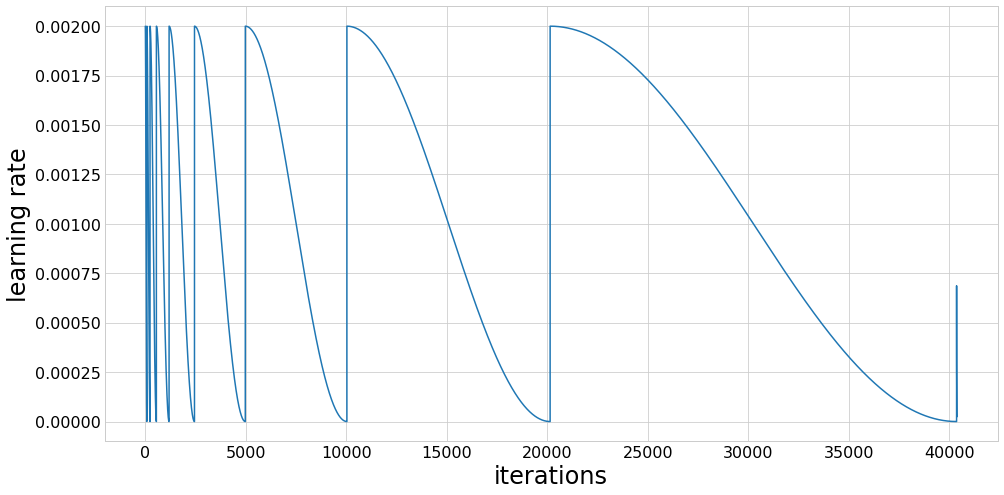

Fold took 628.992s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.579751). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.290448). Check your callbacks.
  % delta_t_median)


1 New best found: 3.940909372871805e-05
2 New best found: 3.576540597031164e-05
3 New best found: 3.492495762452598e-05
5 New best found: 3.396849305204745e-05
6 New best found: 3.344950339760221e-05
7 New best found: 3.3339662962548276e-05
9 New best found: 3.3219879802259856e-05
11 New best found: 3.289577418037043e-05
12 New best found: 3.2807730092404996e-05
13 New best found: 3.247078929663961e-05
14 New best found: 3.2332457035430024e-05
15 New best found: 3.2308453406867386e-05
22 New best found: 3.224436227934604e-05
25 New best found: 3.205048916013345e-05
26 New best found: 3.20343963327676e-05
27 New best found: 3.185695028174724e-05
28 New best found: 3.183432776165939e-05
30 New best found: 3.181963105009032e-05
31 New best found: 3.18160142637513e-05
48 New best found: 3.1667463585401234e-05
50 New best found: 3.156988878453404e-05
54 New best found: 3.153267209661977e-05
55 New best found: 3.150248813535694e-05
56 New best found: 3.146244966789019e-05
57 New best found: 

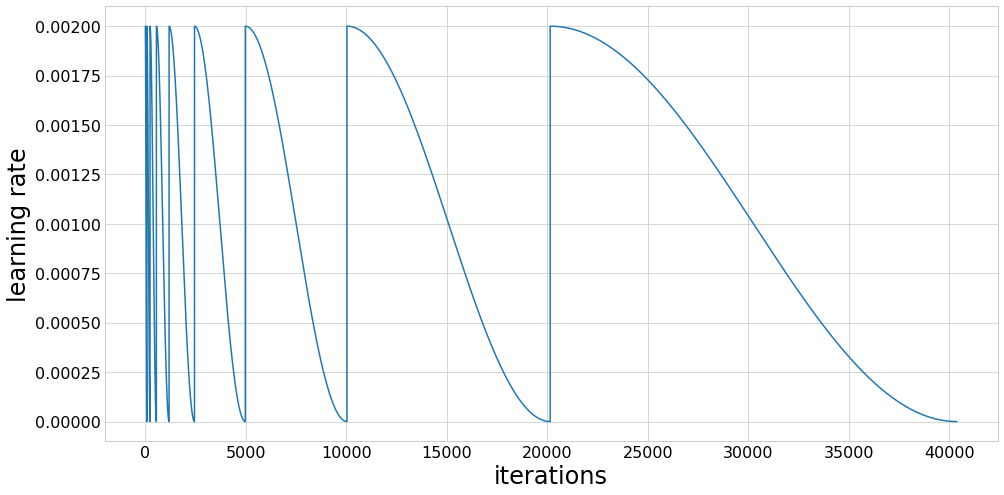

Fold took 629.490s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.557723). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279374). Check your callbacks.
  % delta_t_median)


1 New best found: 4.059054632154319e-05
2 New best found: 3.673241766917529e-05
3 New best found: 3.6370445365647043e-05
4 New best found: 3.60180263679103e-05
5 New best found: 3.5027605322905145e-05
6 New best found: 3.454038164112525e-05
7 New best found: 3.450217094149895e-05
10 New best found: 3.439776298691306e-05
11 New best found: 3.398128815699895e-05
13 New best found: 3.375870920798148e-05
14 New best found: 3.36939151663723e-05
15 New best found: 3.368291300168936e-05
22 New best found: 3.347307440997014e-05
24 New best found: 3.332641060203655e-05
26 New best found: 3.3170029188532385e-05
28 New best found: 3.315743762967845e-05
29 New best found: 3.306853147137798e-05
30 New best found: 3.305445121736906e-05
31 New best found: 3.3049688337331586e-05
46 New best found: 3.304616779705628e-05
47 New best found: 3.301332337141874e-05
49 New best found: 3.2978255898646045e-05
51 New best found: 3.284765665969451e-05
53 New best found: 3.281277207350129e-05
55 New best found: 3

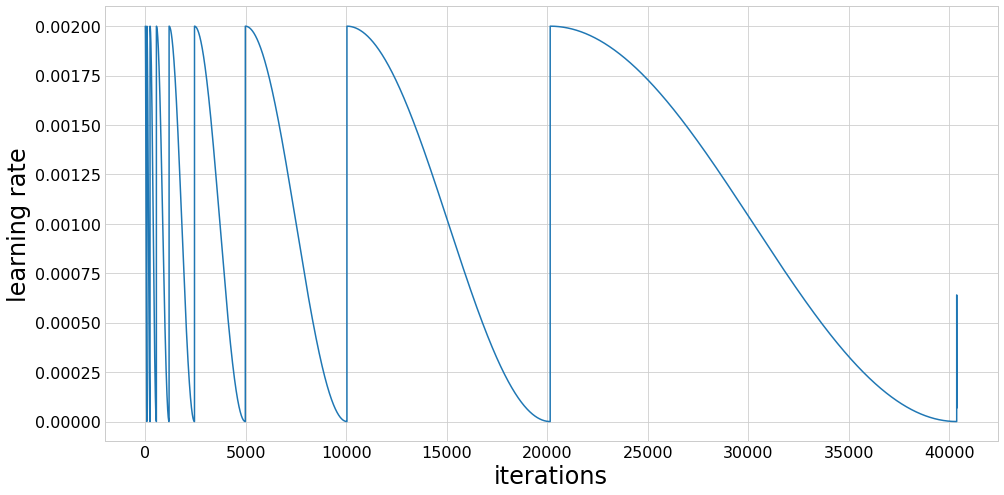

Fold took 638.160s


______________________________________
Training finished
Cross-validation took 4038.995s 


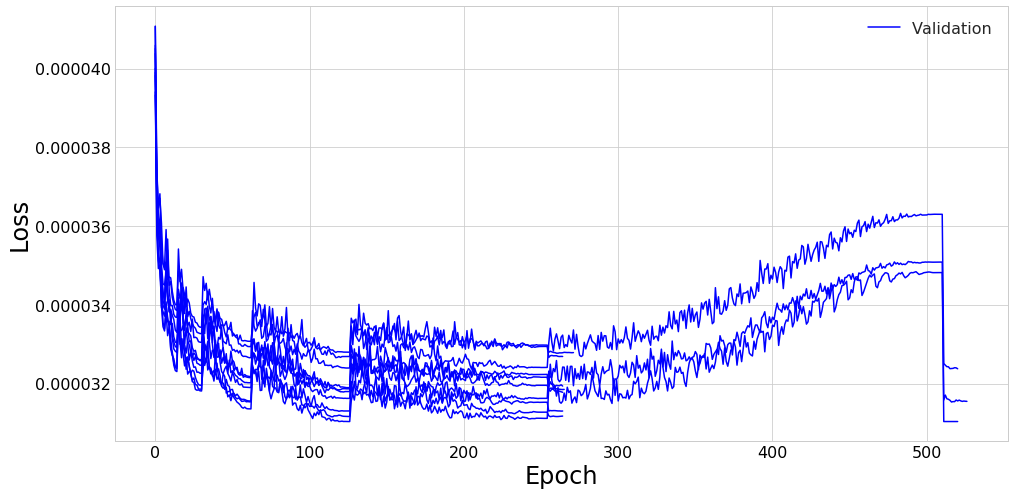

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0636 +- 0.0007
Mean AUC = 0.0989 +- 0.0006
Mean AMS = 3.97 +- 0.07
Mean cut = 0.957 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [12]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [15]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [16]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 8 with loss = 3.103995495527665e-05
Model 1 is 0 with loss = 3.115972012456041e-05
Model 2 is 1 with loss = 3.1300524275866334e-05
Model 3 is 7 with loss = 3.153559279094395e-05
Model 4 is 6 with loss = 3.177088069827516e-05
Model 5 is 2 with loss = 3.184244780422887e-05
Model 6 is 3 with loss = 3.189647128170051e-05
Model 7 is 9 with loss = 3.237377781549557e-05
Model 8 is 4 with loss = 3.266167415068912e-05
Model 9 is 5 with loss = 3.277477579249535e-05


## Response on validation data without TTA

In [17]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0022183809489011766s per sample

Predicting fold 2 out of 10
Prediction took 0.00037612972781062124s per sample

Predicting fold 3 out of 10
Prediction took 0.0003954054780304432s per sample

Predicting fold 4 out of 10
Prediction took 0.00036232839673757555s per sample

Predicting fold 5 out of 10
Prediction took 0.0003719152957201004s per sample

Predicting fold 6 out of 10
Prediction took 0.00036390387490391733s per sample

Predicting fold 7 out of 10
Prediction took 0.00035638493970036506s per sample

Predicting fold 8 out of 10
Prediction took 0.0003667565405368805s per sample

Predicting fold 9 out of 10
Prediction took 0.00036903035789728164s per sample

Predicting fold 10 out of 10
Prediction took 0.0003627089023590088s per sample



In [19]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [20]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9031300605302155, weighted 0.9355549137040562


Best cut at 0.9613201410562785 corresponds to AMS of 3.8420571042110354
Maximum AMS for data is 3.8710415651829257 at cut of 0.9608230590820312
CPU times: user 26.1 s, sys: 0 ns, total: 26.1 s
Wall time: 26.1 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


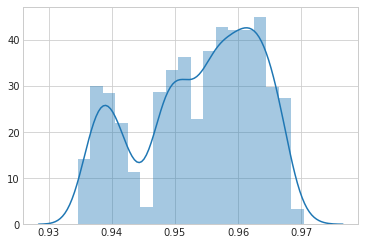

In [21]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9538146 corresponds to AMS of 3.8173679209367846
Maximum AMS for data is 3.8710415651829257 at cut of 0.9608230590820312
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 105 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


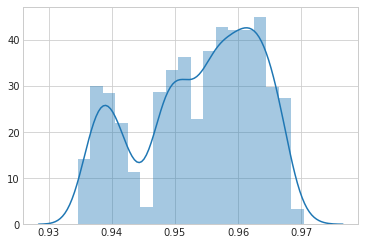

In [22]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [23]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [24]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.006126103191822768s per sample

Predicting fold 2 out of 10
Prediction took 0.006097004738450051s per sample

Predicting fold 3 out of 10
Prediction took 0.006043959410488606s per sample

Predicting fold 4 out of 10
Prediction took 0.006326690047979355s per sample

Predicting fold 5 out of 10
Prediction took 0.00642619427293539s per sample

Predicting fold 6 out of 10
Prediction took 0.0061495546214282515s per sample

Predicting fold 7 out of 10
Prediction took 0.006177074828743935s per sample

Predicting fold 8 out of 10
Prediction took 0.006196116624027491s per sample

Predicting fold 9 out of 10
Prediction took 0.006106352366507054s per sample

Predicting fold 10 out of 10
Prediction took 0.005977304347604513s per sample



In [25]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [26]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9032802401797576, weighted 0.9356170152685995


Best cut at 0.9603911557116427 corresponds to AMS of 3.817946455761534
Maximum AMS for data is 3.859615321780881 at cut of 0.9546077847480774
CPU times: user 26.3 s, sys: 0 ns, total: 26.3 s
Wall time: 26.3 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


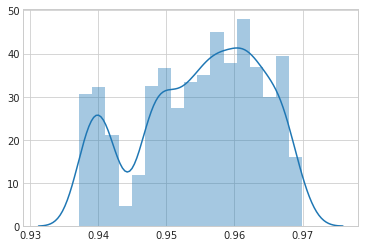

In [27]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95481926 corresponds to AMS of 3.8477972723823433
Maximum AMS for data is 3.859615321780881 at cut of 0.9546077847480774
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 106 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


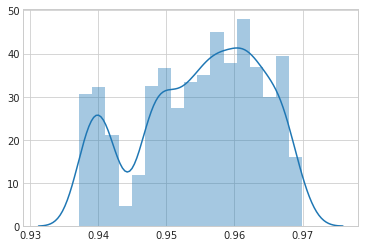

In [28]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [29]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [30]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003623947703702883s per sample

Predicting fold 2 out of 10
Prediction took 0.0003615958753634583s per sample

Predicting fold 3 out of 10
Prediction took 0.000369880972802639s per sample

Predicting fold 4 out of 10
Prediction took 0.0003625333680347963s per sample

Predicting fold 5 out of 10
Prediction took 0.0003643261180682616s per sample

Predicting fold 6 out of 10
Prediction took 0.00036537700512192465s per sample

Predicting fold 7 out of 10
Prediction took 0.00036704490570859473s per sample

Predicting fold 8 out of 10
Prediction took 0.0003634966882792386s per sample

Predicting fold 9 out of 10
Prediction took 0.0003680968337438323s per sample

Predicting fold 10 out of 10
Prediction took 0.0003676235238259489s per sample

CPU times: user 3min 28s, sys: 23.5 s, total: 3min 52s
Wall time: 3min 20s


In [31]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.619206091135655 : 3.7583381443937967


(3.619206091135655, 3.7583381443937967)

In [32]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.784274010012482 : 3.776594043285731


(3.784274010012482, 3.776594043285731)

# Test scoring - With TTA

In [33]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [34]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005922707733850587s per sample

Predicting fold 2 out of 10
Prediction took 0.005908432580937039s per sample

Predicting fold 3 out of 10
Prediction took 0.005880234020271084s per sample

Predicting fold 4 out of 10
Prediction took 0.005943177924914793s per sample

Predicting fold 5 out of 10
Prediction took 0.005936264996162869s per sample

Predicting fold 6 out of 10
Prediction took 0.005967456101287495s per sample

Predicting fold 7 out of 10
Prediction took 0.005931312248110771s per sample

Predicting fold 8 out of 10
Prediction took 0.005933684738183564s per sample

Predicting fold 9 out of 10
Prediction took 0.0059247181172398s per sample

Predicting fold 10 out of 10
Prediction took 0.005915596685964953s per sample

CPU times: user 57min 43s, sys: 5min 57s, total: 1h 3min 41s
Wall time: 54min 19s


In [35]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.643674271228084 : 3.7669259360552694


(3.643674271228084, 3.7669259360552694)

In [36]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.7638801772950328 : 3.7834189624713654


(3.7638801772950328, 3.7834189624713654)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)